# Linear Discriminant Analysis and PCA

This notebook will include my crappy implementation of LDA (and PCA if I'm feeling particularly motivated). These are just for figuring out how they work, using a library written by a proper programmer will be faster and better when I go to use these.

## LDA

The discussion below is partly cribbed from [Wikipedia](https://en.wikipedia.org/wiki/Linear_discriminant_analysis).

Linear discriminant analysis assumes we have some labelled data. The goal is to take the labelled data and project them onto a lower dimensional space which maximises the distance between the mean of the labelled distributions, while minimising the variances of the distributions. If there are two classes (say, neutrons and gammas) the maths is relatively easy to follow:

We have some set of training data $\vec{x}$ in a $k$-dimensional space with known classes $y \epsilon \left[0, 1\right]$.
Assume the PDFs $p\left( \vec{x} | y \right)$ are normally distributed with mean and covariance parameters $\left(\mu_{0}, \Sigma_{0}\right)$ and $\left(\mu_{1}, \Sigma_{1}\right)$, so that the PDF for, say, the 0th class is:

$p\left( \vec{x} | 0 \right) = \left( 2 \pi \right)^{-k/2} \left| \Sigma_{0} \right|^{-1/2} e^{-1/2\left( \vec{x} - \vec{\mu}_{0}\right)' \Sigma_{0}^{-1} \left( \vec{x} - \vec{\mu}_{0} \right)}$

The Bayesian solution to predict some new point $\vec{x}^{*}$ is to just predict points as being from the second class if the ratio of log likelihoods is below some threshold $T$. This is easy to work out to be (multiplying by 2):

$\left(\vec{x}^{*} + \vec{\mu}_{0}\right)'\Sigma_{0}^{-1}\left(\vec{x}^{*} + \vec{\mu}_{0}\right) + \log\left(\left|\Sigma_{0}\right|\right) - \left(\vec{x}^{*} - \vec{\mu}_{1}\right)'\Sigma_{1}^{-1}\left(\vec{x}^{*} + \vec{\mu}_{1}\right) - \log\left(\left|\Sigma_{1}\right|\right) > T $

This is a classifier commonly known as Quadratic Discriminant Analysis (QDA). LDA also assumes homoskedasticity (the covariances are identical for each). In this case (and I haven't done this one by hand), the classification criterion reduces to:

$\lbrace\Sigma^{-1}\left(\vec{\mu_{1}} - \vec{\mu_{0}}\right)\rbrace \cdot \vec{x}^{*} > 1/2\left(T - \vec{\mu_{0}}'\Sigma_{0}^{-1}\vec{\mu_{0}} + \vec{\mu_{1}}'\Sigma_{1}^{-1}\vec{\mu_{1}} \right)$

The geometric interpretation is that the left hand side of the above is a projection of the vector $\vec{x}^{*}$ onto $\Sigma^{-1}\left(\vec{\mu_{1}} - \vec{\mu_{0}}\right)$, where the latter is normal to the discrimination hyperplane. This is all well and good, but how are $\vec{\mu_{0}}$, $\vec{\mu_{1}}$, and $\Sigma$ defined? Well, it seems they are just estimated from the data.

### Fisher's Linear Discriminant

Fisher's linear discriminant is defined a little differently (and generally), and I find it more intuitive. It is more in-keeping with what I said above about maximising the difference between the means and minimising the variance (which is like optimising the classification signal-to-noise ratio).

Suppose the two classes have means $\vec{\mu}_{0}$, $\vec{\mu}_{1}$ and covariances $\Sigma_{0}$, $\Sigma_{1}$. We can come up with a linear combination of the features in the vector $\vec{x}^{*}$ by taking a dot product $\vec{w} \cdot \vec{x}^{*}$. This dot product will have means $\vec{w}\cdot\vec{\mu}_{i}$ and variances $\vec{w}'\Sigma_{i}\vec{w}$ for the $i$th class. The trick is to optimise the separation between the classes while minimising the variances, so maximise this expression:

$S = \frac{\left(\vec{w}\cdot\vec{\mu}_{1} - \vec{w}\cdot\vec{\mu}_{0}\right)^{2}}{\vec{w}'\Sigma_{1}\vec{w} + \vec{w}'\Sigma_{0}\vec{w}}$

Fisher showed that $S$ is maximised when:

$\vec{w} \propto \left(\Sigma_{0} + \Sigma_{1}\right)^{-1} \left(\vec{\mu}_{1} - \vec{\mu}_{0}\right)$

OK, that looks like something I can calculate. For the specific case of PSD, the means are the mean channel values, and the covariance is the covariance between the channels. I think I understand better now why my LDA worked so well for the SABRE-like PSD case: the energy window was quite narrow, so that the estimate of the mean wasn't smeared out by the variation in the pulse height. This suggests that I should slice the data up into as-narrow-as-possible total charge sub-samples and then do discriminant analysis on that.

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

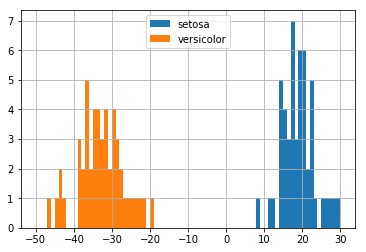

In [4]:
#OK, let's do this. I'll start by playing with the iris dataset.
iris = datasets.load_iris()

X = iris.data #iris data has 4 features and 150 samples.
y = iris.target #there are 3 classes. Let's just compare the first 2, since > 2 is possible but a pain.
target_names = iris.target_names

mu_0 = np.mean(X[y==0], axis=0)
cov_0 = np.cov(X[y==0], rowvar=False)
mu_1 = np.mean(X[y==1], axis=0)
cov_1 = np.cov(X[y==1], rowvar=False)
w = np.dot(np.linalg.inv(cov_0 + cov_1), mu_0 - mu_1)

plt.hist(np.dot(X[y==0],w), bins=80, range=(-50,30), label='{0}'.format(target_names[0]))
plt.hist(np.dot(X[y==1],w), bins=80, range=(-50,30), label='{0}'.format(target_names[1]))
plt.grid()
plt.legend(loc='upper center')

Nice! That's so easy I'm genuinely surprised that it works so well. Let's try the same thing with some SABRE-like PSD data:

In [14]:
def get_wfm(particle_type, scalefactor=1):
    """
    Return the unmodified waveform for a particle interaction ('gamma' or 'neutron').
    """
    #Scintillator parameters
    t_r = 1.
    t_f = 10.
    t_s = 100.
    if 'gamma' in particle_type.lower():
        A_f = 0.8
        A_s = 0.2
    elif 'neutron' in particle_type.lower():
        A_f = 0.5
        A_s = 0.5
    else:
        print("Error: Unknown particle type {0}".format(particle_type))

    xvals = np.linspace(0, 1000, 5001)
    yvals = (1-np.exp(-xvals/t_r))*(A_f*np.exp(-xvals/t_f) + A_s*np.exp(-xvals/t_s))
    return np.random.exponential(scale=scalefactor)*yvals/np.abs(sum(yvals))

#Set up convolution parameters
#For few photon events the PMT's broadening should have a relatively greater impact.
conv_sigma = 5
conv_mean = 0
convrange = conv_sigma*5
conv_kernel = (1./np.sqrt(2*np.pi*conv_sigma**2))*np.exp(-0.5*(((np.linspace(-convrange,convrange,convrange+1)
                                                                 -conv_mean)/conv_sigma)**2))
conv_mode = 'same'

noise_lvl = 0.0002
scale_factor = 0.05

Ngammas = 5000 #12000 x 1000 array ~ 96 MB
Gammas = np.random.normal(0, noise_lvl, (12000, Ngammas))
for i in range(Ngammas):
    Gammas[1999:, i] += get_wfm('gamma', scalefactor=scale_factor)
    Gammas[:, i] = np.convolve(Gammas[:, i], conv_kernel, mode = conv_mode)
    
Nneutrons = 5000 #12000 x 1000 array ~ 96 MB
Neutrons = np.random.normal(0, noise_lvl, (12000, Nneutrons))
for i in range(Nneutrons):
    Neutrons[1999:, i] += get_wfm('neutrons', scalefactor=scale_factor)
    Neutrons[:, i] = np.convolve(Neutrons[:, i], conv_kernel, mode = conv_mode)


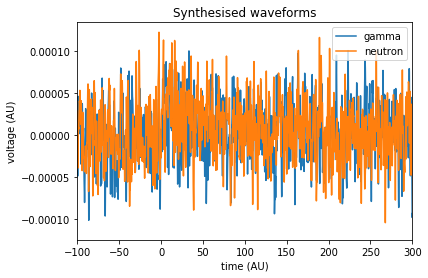

In [17]:
timevals = np.linspace(-200, 1000, len(Neutrons[:,0]))
plt.plot(timevals, Gammas[:,0], label='gamma')
plt.plot(timevals, Neutrons[:,0], label='neutron')
plt.xlim(-100,300)
plt.xlabel('time (AU)')
plt.ylabel('voltage (AU)')
plt.title('Synthesised waveforms')
plt.legend(loc='upper right')

Crude FOM: 0.00805662724486
Half-way cut: 0.26370286264
905


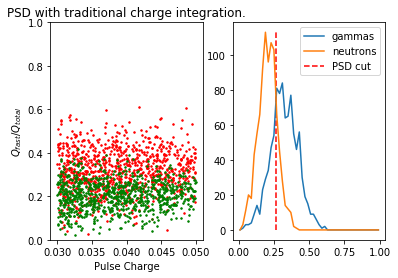

In [18]:
MaxCharge = 0.05
MinCharge = 0.03

#Lets define the fast integration region as 190:220, and the total integration region as 190:.
Qf_gamma = np.sum(Gammas[1900:2200, :], axis=0)
Qt_gamma = np.sum(Gammas[1900:, :], axis=0)

Qf_neut = np.sum(Neutrons[1900:2200, :], axis=0)
Qt_neut = np.sum(Neutrons[1900:, :], axis=0)

selectedQt_gamma = Qt_gamma[(Qt_gamma<MaxCharge)&(Qt_gamma>MinCharge)]
selectedPSD_gamma = (Qf_gamma/Qt_gamma)[(Qt_gamma<MaxCharge)&(Qt_gamma>MinCharge)]
selectedQt_neut = Qt_neut[(Qt_neut<MaxCharge)&(Qt_neut>MinCharge)]
selectedPSD_neut = (Qf_neut/Qt_neut)[(Qt_neut<MaxCharge)&(Qt_neut>MinCharge)]

plt.subplot(1,2,1)
plt.plot(selectedQt_gamma, selectedPSD_gamma, 'r.', markersize=3, label='SABRE Gammas')
plt.plot(selectedQt_neut, selectedPSD_neut, 'g.', markersize=3, label='SABRE Neutrons')
plt.ylim(0,1)
plt.xlabel("Pulse Charge")
plt.ylabel("$Q_{fast}/Q_{total}$")
plt.title('PSD with traditional charge integration.')

PSDg, binedges = np.histogram(selectedPSD_gamma, bins=50, range=(0,1))
bincentres = binedges[:-1] + (binedges[1]-binedges[0])/2
PSDn, binedges = np.histogram(selectedPSD_neut, bins=50, range=(0,1))
plt.subplot(1,2,2)
plt.plot(bincentres, PSDg, label='gammas')
plt.plot(bincentres, PSDn, label='neutrons')
print("Crude FOM: {0}".format((np.mean(selectedPSD_gamma)- np.mean(selectedPSD_neut))/
                              2.35482*(np.std(selectedPSD_gamma)+ np.std(selectedPSD_neut))))
PSDcut = (np.mean(selectedPSD_gamma)+ np.mean(selectedPSD_neut))/2
print("Half-way cut: {0}".format(PSDcut))
plt.vlines(PSDcut, ymin=0, ymax=max((max(PSDg), max(PSDn))), 
           colors='r', linestyles='dashed', label='PSD cut')
plt.legend()
print(sum(PSDn))

OK, those data look suitably difficult to disentangle.

Let's see how the traditional PSD approach performs:

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

False positive neutron rate < 0.2 for PSD cut at 0.240868345653
f1 score: 0.733527696793
Confusion matrix, without normalization
[[750 180]
 [277 629]]
Normalized confusion matrix
[[ 0.81  0.19]
 [ 0.31  0.69]]


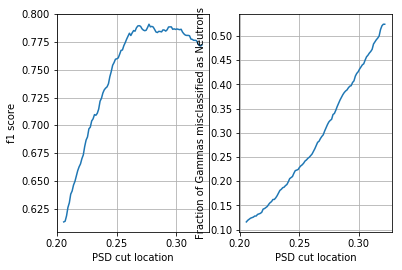

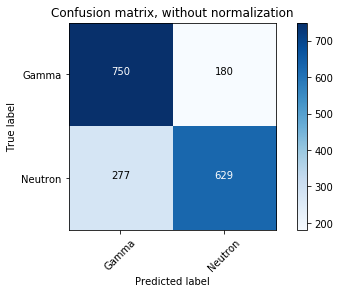

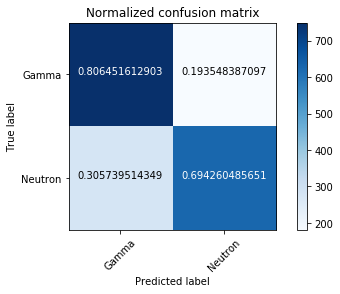

In [22]:
#Let's repeat the above Qfast/Qtotal analysis, but rather than using f1, find the value which makes the probability of
#misclassifying a gamma event as a neutron event < 0.01:
PSDcut_min = min((np.mean(selectedPSD_gamma), np.mean(selectedPSD_neut)))
PSDcut_max = max((np.mean(selectedPSD_gamma), np.mean(selectedPSD_neut)))

y_true = np.concatenate((np.array([0]*len(selectedPSD_gamma)),
                         np.array([1]*len(selectedPSD_neut))))

PSDcut_vector = np.linspace(PSDcut_min, PSDcut_max, 100)
f1scores = np.empty(len(PSDcut_vector), dtype=np.float64)
FalsePositive = np.empty(len(PSDcut_vector), dtype = np.float64)

for i, thisPSDcut in enumerate(PSDcut_vector):
    Neuts_predict = [0 if PSD > thisPSDcut else 1 for PSD in selectedPSD_neut]
    Gammas_predict = [0 if PSD > thisPSDcut else 1 for PSD in selectedPSD_gamma]
    y_pred = np.concatenate((Gammas_predict, Neuts_predict))
    f1scores[i] = f1_score(y_true, y_pred)
    CM = confusion_matrix(y_true, y_pred)
    FalsePositive[i] = (CM/(np.sum(CM, axis=1)*1.0))[0,1]

PSDcut_optim = max(PSDcut_vector[FalsePositive<0.2])
print("False positive neutron rate < 0.2 for PSD cut at {0}".format(PSDcut_optim))
plt.subplot(1,2,1)
plt.plot(PSDcut_vector, f1scores)
plt.grid()
plt.ylabel('f1 score')
plt.xlabel('PSD cut location')

plt.subplot(1,2,2)
plt.plot(PSDcut_vector, FalsePositive)
plt.grid()
plt.ylabel('Fraction of Gammas misclassified as Neutrons')
plt.xlabel('PSD cut location')

#repeat it for the optimal PSD cut:
Neuts_predict = [0 if PSD > PSDcut_optim else 1 for PSD in selectedPSD_neut]
Gammas_predict = [0 if PSD > PSDcut_optim else 1 for PSD in selectedPSD_gamma]
y_pred_optim = np.concatenate((Gammas_predict, Neuts_predict))
cnf_matrix_optim = confusion_matrix(y_true, y_pred_optim)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y_true, y_pred_optim)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_optim, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_optim, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

So that's underwhelming performance from the traditional $Q_{fast}/Q_{total}$ PSD.

What about Fisher's linear discriminant?

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 1860 but corresponding boolean dimension is 1836
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 1860 but corresponding boolean dimension is 1836
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 1860 but corresponding boolean dimension is 1836
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 1860 but corresponding boolean dimension is 1836
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 1860 but correspon

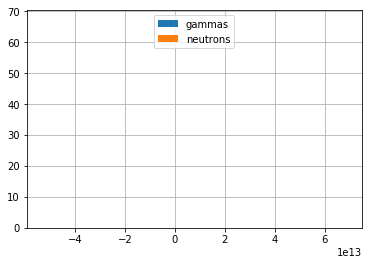

In [23]:
gammaselectionmask = (Qt_gamma<MaxCharge)&(Qt_gamma>MinCharge)
neutronselectionmask = (Qt_neut<MaxCharge)&(Qt_neut>MinCharge)

X_PSD = np.concatenate((Gammas[:,gammaselectionmask], Neutrons[:,neutronselectionmask]), axis=1)
y_PSD = np.concatenate(([0]*np.shape(Gammas[:,gammaselectionmask])[1], 
                        [1]*np.shape(Neutrons[:,neutronselectionmask])[1])
mu_g = np.mean(X_PSD[:,y_PSD==0], axis=1)
cov_g = np.cov(X_PSD[:,y_PSD==0])#, rowvar=False)
mu_n = np.mean(X_PSD[:,y_PSD==1], axis=1)
cov_n = np.cov(X_PSD[:,y_PSD==1])#, rowvar=False)
w = np.dot(np.linalg.inv(cov_g + cov_n), mu_g - mu_n)

plt.hist(np.dot(w,X_PSD[:,y_true==0]), bins=50, label='gammas')
plt.hist(np.dot(w,X_PSD[:,y_true==1]), bins=50, label='neutrons')
plt.grid()
plt.legend(loc='upper center')

In [24]:
w[1997:2003]

array([ -1.52e+18,   2.77e+18,  -1.76e+17,  -1.97e+18,  -1.99e+18,
         1.12e+17])

In [90]:
print(mu_g[1997:2002])
cov_g[1997:2002,1997:2002]

[  5.23e-06   7.30e-06   1.03e-05   1.42e-05   1.91e-05]


array([[  2.46e-09,   2.35e-09,   2.07e-09,   1.68e-09,   1.26e-09],
       [  2.35e-09,   2.45e-09,   2.34e-09,   2.07e-09,   1.69e-09],
       [  2.07e-09,   2.34e-09,   2.44e-09,   2.34e-09,   2.08e-09],
       [  1.68e-09,   2.07e-09,   2.34e-09,   2.44e-09,   2.35e-09],
       [  1.26e-09,   1.69e-09,   2.08e-09,   2.35e-09,   2.45e-09]])

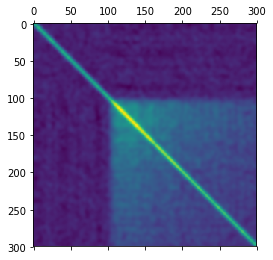

In [26]:
#Let's plot the covariance matrix:
plt.matshow(cov_g[1900:2200,1900:2200])

In [51]:
np.shape(Gammas[:,selectionmask])

(12000L, 930L)

In [52]:
np.shape(Gammas)

(12000L, 5000L)

In [27]:
ret = np.dot(w,X_PSD)

In [36]:
print("{0:.2e}".format(np.median(ret)))

-5.33e+13


In [50]:
np.sum(selectionmask)

930

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1860 but corresponding boolean dimension is 1836
  app.launch_new_instance()


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   3.,   2.,   0.,   2.,   4.,   1.,   0.,
          1.,   4.,   2.,   1.,   3.,   4.,   3.,   3.,   6.,   5.,   8.,
          7.,   6.,   9.,   7.,   8.,  11.,  14.,  13.,  15.,  23.,  15.,
         13.,  15.,  22.,  11.,  17.,  26.,  21.,  22.,  24.,  24.,  31.,
         31.,  28.,  28.,  25.,  28.,  21.,  31.,  29.,  22.,  22.,  30.,
          9.,  17.,  23.,  17.,  11.,  11.,  12.,  14.,  12.,  13.,  14.,
          5.,   9.,   3.,   9.,   6.,   4.,   5.,   4.,   3.,   3.,   2.,
          5.,   9.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          2.]),
 array([ -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,
         -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,
         -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,
         -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,  -5.33e+13,
         -5.33e+13,  -5.33e+13,  -5.33e+13,  -

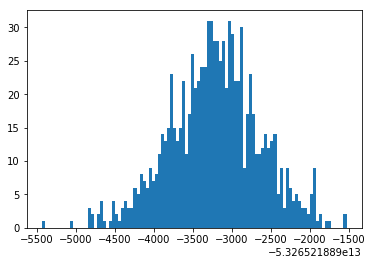

In [42]:
#shiftret = ret + min(ret) + 1
#plt.hist(shiftret, bins=np.logspace(0.1, 1e31, 50))
plt.hist(ret[y_true==0], bins=100)

OK, WTF?!!!